In [19]:
import numpy as np
import pandas as pd
import xgboost as xgb
import operator
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, GroupKFold, GridSearchCV, GroupShuffleSplit

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

%matplotlib inline
plt.rcParams['figure.dpi'] = 400
plt.rcParams['figure.figsize'] = (4, 3) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
all_data = pickle.load(open('all_data.pkl', 'rb'))

In [3]:
all_data.head()

,tube_assembly_id,supplier,annual_usage,min_order_quantity,bracket_pricing,quantity,cost,material_id,diameter,wall,...,thread_end_form_id,thread_number,total_comp_number,total_weight,min_weight,max_weight,mean_weight,year,month,cross_section
id,,,,,,,,,,,,,,,,,,,,,
0,2,S-0066,0,0,Yes,1.00,21.905933,SP-0019,6.35,0.71,...,0.0,0.0,2.0,0.018,0.018,0.018,0.018,2013,7,8.5129
-1,2,S-0066,0,0,Yes,0.50,12.341214,SP-0019,6.35,0.71,...,0.0,0.0,2.0,0.018,0.018,0.018,0.018,2013,7,8.5129
-2,2,S-0066,0,0,Yes,0.20,6.601826,SP-0019,6.35,0.71,...,0.0,0.0,2.0,0.018,0.018,0.018,0.018,2013,7,8.5129
-3,2,S-0066,0,0,Yes,0.10,4.687770,SP-0019,6.35,0.71,...,0.0,0.0,2.0,0.018,0.018,0.018,0.018,2013,7,8.5129
-4,2,S-0066,0,0,Yes,0.04,3.541561,SP-0019,6.35,0.71,...,0.0,0.0,2.0,0.018,0.018,0.018,0.018,2013,7,8.5129


In [4]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60448 entries, 0 to 30235
Columns: 176 entries, tube_assembly_id to cross_section
dtypes: bool(4), float64(158), int64(9), object(5)
memory usage: 80.0+ MB


In [5]:
# label encoding categorical data
# df_numeric = all_data.select_dtypes(exclude=['object'])
# df_obj = all_data.select_dtypes(include=['object']).copy()

# for c in df_obj:
#     df_obj[c] = LabelEncoder().fit_transform(df_obj[c].astype(str))

# all_data = pd.concat([df_numeric, df_obj], axis=1)

In [6]:
# One hot encoding categorical data
all_data = pd.get_dummies(all_data)

# drop all zero columns
all_data = all_data.loc[:, (all_data != 0).any(axis=0)]
all_data = all_data.astype('float')

In [7]:
train_df = all_data.loc[all_data.index <= 0, :]
ylog_train = np.log1p(train_df['cost']).as_matrix()
train_df = train_df.drop('cost', axis=1)
test_df = all_data.loc[all_data.index > 0, :]
test_df = test_df.drop('cost', axis=1)

X_train = train_df.as_matrix()
X_test = test_df.as_matrix()

# split training data into training and validation
X_train_all = X_train.copy()
ylog_train_all = ylog_train.copy()

In [8]:
X_train.shape, X_test.shape, ylog_train.shape

((30213, 305), (30235, 305), (30213,))

In [9]:
# without split 
# df_columns = train_df.columns
# dtrain = xgb.DMatrix(X_train, ylog_train, feature_names=df_columns, missing=-999.0)
# dtest = xgb.DMatrix(X_test, feature_names=df_columns)

tube_id_index = train_df.columns.get_loc('tube_assembly_id')
splitter = GroupShuffleSplit(n_splits = 1, test_size = 0.2)
split = splitter.split(X_train_all, ylog_train_all, X_train_all[:, tube_id_index])

for train_index, val_index in split:
    X_train = X_train_all[train_index, :]
    X_val = X_train_all[val_index, :]
    ylog_train = ylog_train_all[train_index]
    ylog_val = ylog_train_all[val_index]



df_columns = train_df.columns
dtrain = xgb.DMatrix(X_train, ylog_train, feature_names=df_columns, missing=-999.0)
dval = xgb.DMatrix(X_val, feature_names=df_columns, missing=-999.0)
dtest = xgb.DMatrix(X_test, feature_names=df_columns)

In [10]:
train_index.shape

(24039,)

In [11]:
val_index.shape

(6174,)

In [12]:
X_train.shape, X_val.shape, ylog_train.shape, ylog_val.shape

((24039, 305), (6174, 305), (24039,), (6174,))

In [13]:
# xgb_reg = xgb.XGBRegressor(max_depth=8, learning_rate=0.1,
#                                n_estimators=2000, silent=True, 
#                                objective='reg:linear')

# # # kfold = KFold(n_splits=5, random_state=7, shuffle = False)
# gkf = GroupKFold(n_splits=5)
# for train, valid in gkf.split(X_train, ylog_train, train_df['tube_assembly_id'].values):
#     xgb_model = xgb_reg.fit(X_train[train], ylog_train[train])
#     predictions = xgb_model.predict(X_train[valid])
#     actuals = ylog_train[valid]
#     print(np.sqrt(mean_squared_error(actuals, predictions)))

In [14]:
# use sklearn wrapper grid search for hyper parameters
# grouped K-fold to make sure the data with the same tube_assembly_id 
# will not splitted
# gkf = GroupKFold(n_splits=5)
# xgb_reg = xgb.XGBRegressor()
# cv = gkf.split(X_train, ylog_train, train_df['tube_assembly_id'].values)
# clf = GridSearchCV(xgb_reg,
#                    {'max_depth': [4, 6, 8, 10],
#                     'n_estimators': [10, 20, 30, 40]}, verbose=1, 
#                    cv = cv,
#                   error_score = 'mean_square_error', n_jobs = 1)

# clf.fit(X_train,ylog_train)
# print(clf.best_score_)
# print(clf.best_params_)
# ylog_pred = clf.predict(X_test)

In [22]:
cv_results = {}
max_num_boost_round = 6000
max_depth = [4, 6, 8, 10, 12]

test_1se_error = []


# To create feacture map
def ceate_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1
    outfile.close()
ceate_feature_map(df_columns)


# cross-validation to tune max depth and boosting rounds number
for i in range(len(max_depth)):
    xgb_params = {
        'eta': 0.05,
        'max_depth': max_depth[i],
        'subsample': 0.7,
        'colsample_bytree': 0.7,
        'objective': 'reg:linear',
        'eval_metric': 'rmse',
        'silent': 1,
        'min_child_weight': 3,
        'gamma': 0.3
    }
    
    # print progress
    print('cv for max tree depth = {0}'.format(max_depth[i]))
        
    # create grouped folds based on tube_assembly_id
    gkf = GroupKFold(n_splits=5)
    
    cv = gkf.split(X_train, ylog_train, X_train[:, tube_id_index])
    cv_result = xgb.cv(xgb_params, dtrain, nfold=5, num_boost_round=max_num_boost_round, 
                       folds=cv, early_stopping_rounds=20,
       verbose_eval=100, show_stdv=True)
    
    # using cross -validation to find the optimal number of boosting rounds using min cv error rule and 1se rul
    num_boost_rounds_min = len(cv_result)  
    print("Optimal number of boosting rounds for max tree depth = {0} using min cv error rule = {1}".format(
            max_depth[i], num_boost_rounds_min))
    
    # number of rounds = index + 1
    num_boost_rounds_1se = np.argwhere(cv_result['test-rmse-mean'] <= 
                                      cv_result.iloc[-1, 0] + cv_result.iloc[-1, 1])[0]+1
    num_boost_rounds_1se = int(num_boost_rounds_1se)
    print("Optimal number of boosting rounds for max tree depth = {0} using one standard error rule = {1}".format(
            max_depth[i], num_boost_rounds_1se))
    
    # cv_result[['train-rmse-mean', 'test-rmse-mean']].plot()
    # plt.show()
    

    
    model_min = xgb.train(xgb_params, dtrain, num_boost_round=num_boost_rounds_min, verbose_eval=20)
    ylog_pred_min = model_min.predict(dval)
    test_error_min = np.sqrt(mean_squared_error(ylog_pred_min, ylog_val))
    print("Test RMSLE for max tree depth = {0} using min cv error rule = {1}".format(
            max_depth[i], test_error_min))
    
    model_1se = xgb.train(xgb_params, dtrain, num_boost_round=num_boost_rounds_1se, verbose_eval=20)
    ylog_pred_1se = model_1se.predict(dval)
    test_error_1se = np.sqrt(mean_squared_error(ylog_pred_1se, ylog_val))
    print("Test RMSLE for max tree depth = {0} using one standard error rule = {1}".format(
            max_depth[i], test_error_1se))
    
    importance = model_min.get_fscore(fmap='xgb.fmap')
    importance = sorted(importance.items(), key=operator.itemgetter(1))

    feature_importance = pd.DataFrame(importance, columns=['feature', 'fscore'])
    feature_importance['fscore'] = feature_importance['fscore'] / feature_importance['fscore'].sum()
    
    cv_results[str(max_depth[i])] = [cv_result, feature_importance, 
                                     num_boost_rounds_min,  num_boost_rounds_1se
                                    test_error_min, test_error_1se]   
    
    ylog_pred_test = model_min.predict(dtest)
    y_pred = np.exp(ylog_pred_test) - 1
    df_sub = pd.DataFrame({'id': test_df.index, 'cost': y_pred})
    df_sub = df_sub.set_index('id')
    filename = 'Predict_xgb_depth'+ str(max_depth[i]) + '.csv'
    df_sub.to_csv(filename, index=True)

cv for max tree depth = 4
[0]	train-rmse:1.80695+0.00166417	test-rmse:1.80697+0.0129082
[100]	train-rmse:0.298556+0.00291649	test-rmse:0.327776+0.00981001
[200]	train-rmse:0.260299+0.00296485	test-rmse:0.302199+0.00991218
[300]	train-rmse:0.240178+0.00226709	test-rmse:0.29015+0.0100859
[400]	train-rmse:0.224862+0.00246047	test-rmse:0.281602+0.0102056
[500]	train-rmse:0.213325+0.0015473	test-rmse:0.27571+0.0096571
[600]	train-rmse:0.20367+0.0019717	test-rmse:0.271073+0.00980714
[700]	train-rmse:0.195163+0.00236779	test-rmse:0.267273+0.00965971
[800]	train-rmse:0.18869+0.00194384	test-rmse:0.264636+0.00917801
[900]	train-rmse:0.18253+0.00184649	test-rmse:0.262122+0.00895657
[1000]	train-rmse:0.178274+0.0017989	test-rmse:0.260322+0.00867822
[1100]	train-rmse:0.173374+0.00143779	test-rmse:0.258503+0.00905549
[1200]	train-rmse:0.169868+0.00170379	test-rmse:0.257117+0.00893253
[1300]	train-rmse:0.166992+0.00156423	test-rmse:0.256016+0.00919214
[1400]	train-rmse:0.164282+0.00185423	test-rmse:

In [16]:
#Dump the data for future usage
pickle.dump(cv_results, open('xgb_cv_results.pkl', 'wb'))

In [15]:
max_depth = [4, 6, 8, 10, 12]

cv_results = pickle.load(open('xgb_cv_results.pkl', 'rb'))
cv_RMSE_min = np.zeros(len(max_depth))
cv_std_min = np.zeros(len(max_depth))
cv_RMSE_1se = np.zeros(len(max_depth))
cv_std_1se = np.zeros(len(max_depth))
boosting_rounds_min = np.zeros(len(max_depth))
boosting_rounds_1se = np.zeros(len(max_depth))

for i in range(len(max_depth)):
    print("Max tree depth = {0}".format(i))
    print("minimum cv error rule")
    print(cv_results[str(max_depth[i])][0].iloc[-1,])
    cv_RMSE_min[i] = cv_results[str(max_depth[i])][0].iloc[-1,0]
    cv_std_min[i] = cv_results[str(max_depth[i])][0].iloc[-1,1]
    boosting_rounds_min[i] = cv_results[str(max_depth[i])][2]
    
    print("\n")
    print("One standard error rule")
    boosting_rounds_1se[i] = cv_results[str(max_depth[i])][3]
    print(cv_results[str(max_depth[i])][0].iloc[num_rounds_1se-1,])
    cv_RMSE_1se[i] = cv_results[str(max_depth[i])][0].iloc[num_rounds_1se-1,0]
    cv_std_1se[i] = cv_results[str(max_depth[i])][0].iloc[num_rounds_1se-1,1]

Max tree depth = 0
minimum cv error rule
test-rmse-mean     0.254479
test-rmse-std      0.009028
train-rmse-mean    0.162005
train-rmse-std     0.001958
Name: 1493, dtype: float64


One standard error rule
test-rmse-mean     0.327260
test-rmse-std      0.009631
train-rmse-mean    0.297914
train-rmse-std     0.002946
Name: 101, dtype: float64
Max tree depth = 1
minimum cv error rule
test-rmse-mean     0.243335
test-rmse-std      0.010830
train-rmse-mean    0.124845
train-rmse-std     0.000794
Name: 1494, dtype: float64


One standard error rule
test-rmse-mean     0.283943
test-rmse-std      0.010584
train-rmse-mean    0.225869
train-rmse-std     0.003092
Name: 101, dtype: float64
Max tree depth = 2
minimum cv error rule
test-rmse-mean     0.244782
test-rmse-std      0.011053
train-rmse-mean    0.117721
train-rmse-std     0.001480
Name: 740, dtype: float64


One standard error rule
test-rmse-mean     0.267373
test-rmse-std      0.011037
train-rmse-mean    0.178215
train-rmse-std     0.00

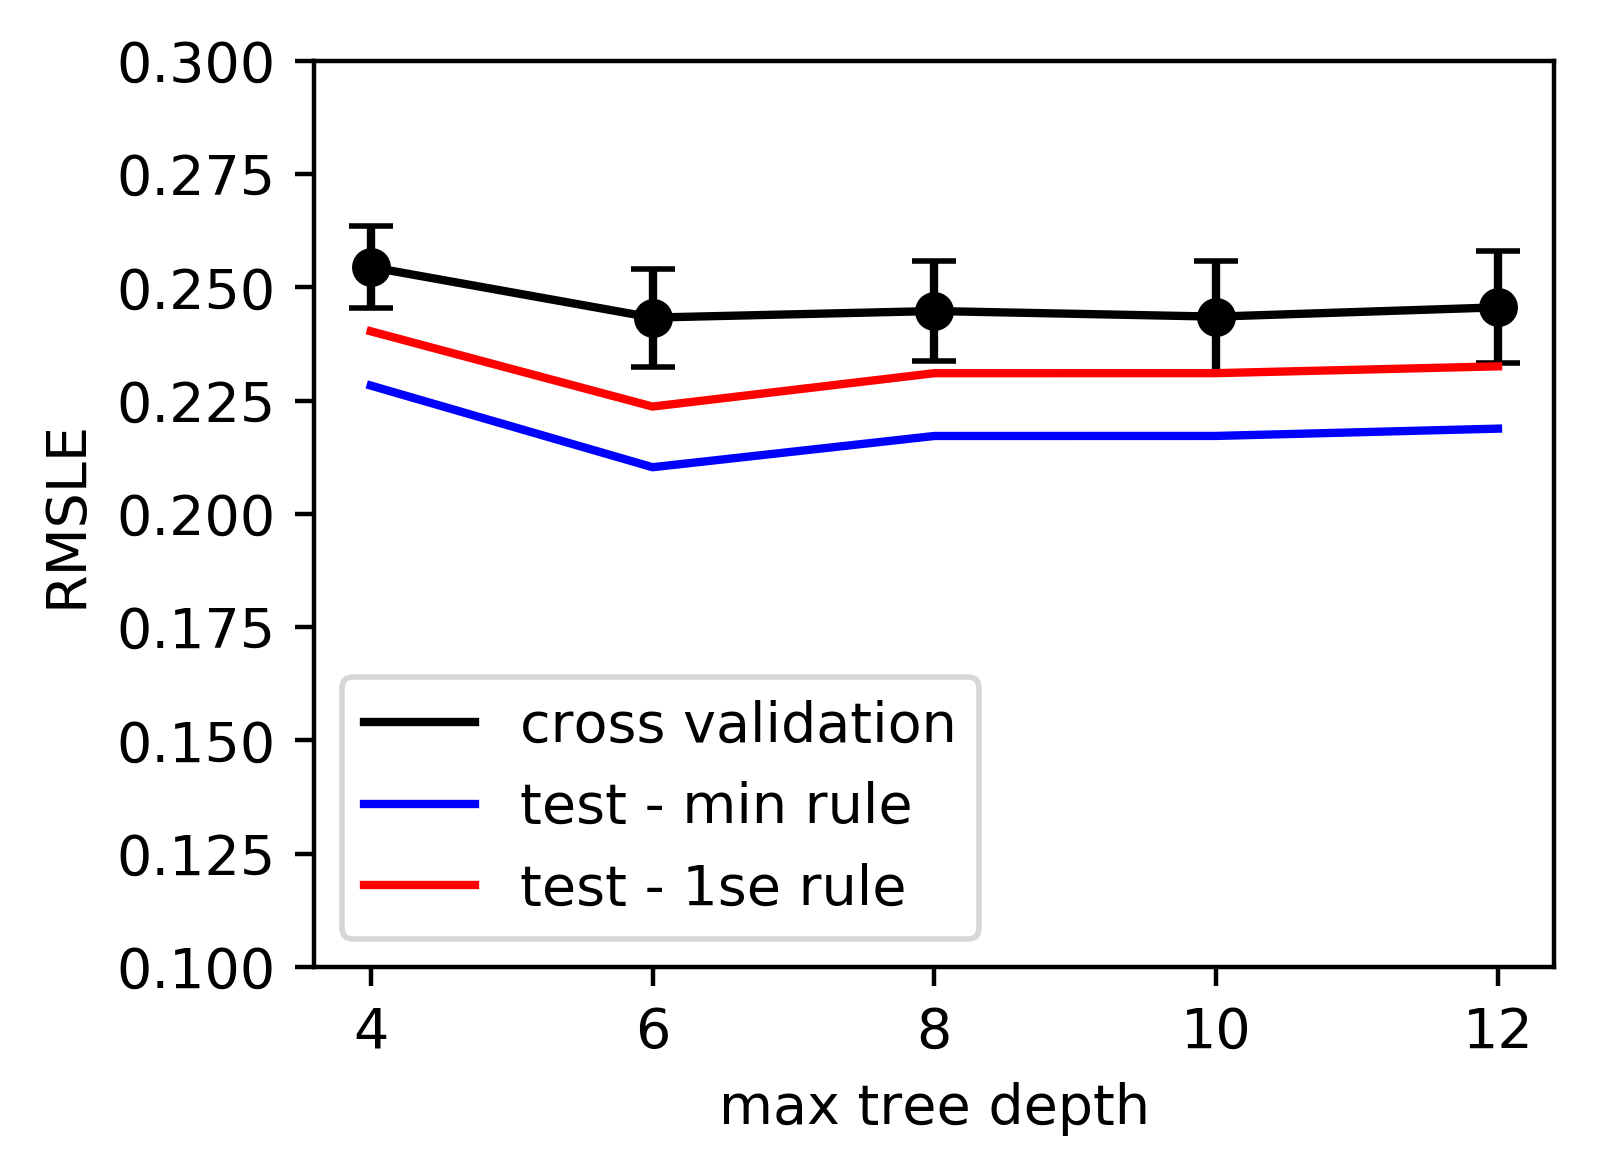

In [20]:
test_error_min = [0.22833, 0.21030, 0.21720, 0.21721, 0.21882]
test_error_1se = [0.24031, 0.22369, 0.23106, 0.23107, 0.23257]
plt.errorbar(max_depth, cv_RMSE_min, yerr = cv_std_min, fmt = 'o', color = 'k', capsize = 4)
plt.plot(max_depth, cv_RMSE_min, label = 'cross validation', color = 'k')

plt.plot(max_depth, test_error_min, label = 'test - min rule', color = 'b')
plt.plot(max_depth, test_error_1se, label = 'test - 1se rule', color = 'r')
plt.ylim([0.1, 0.3])
plt.xlabel("max tree depth")
plt.ylabel('RMSLE')
plt.legend()
plt.show()

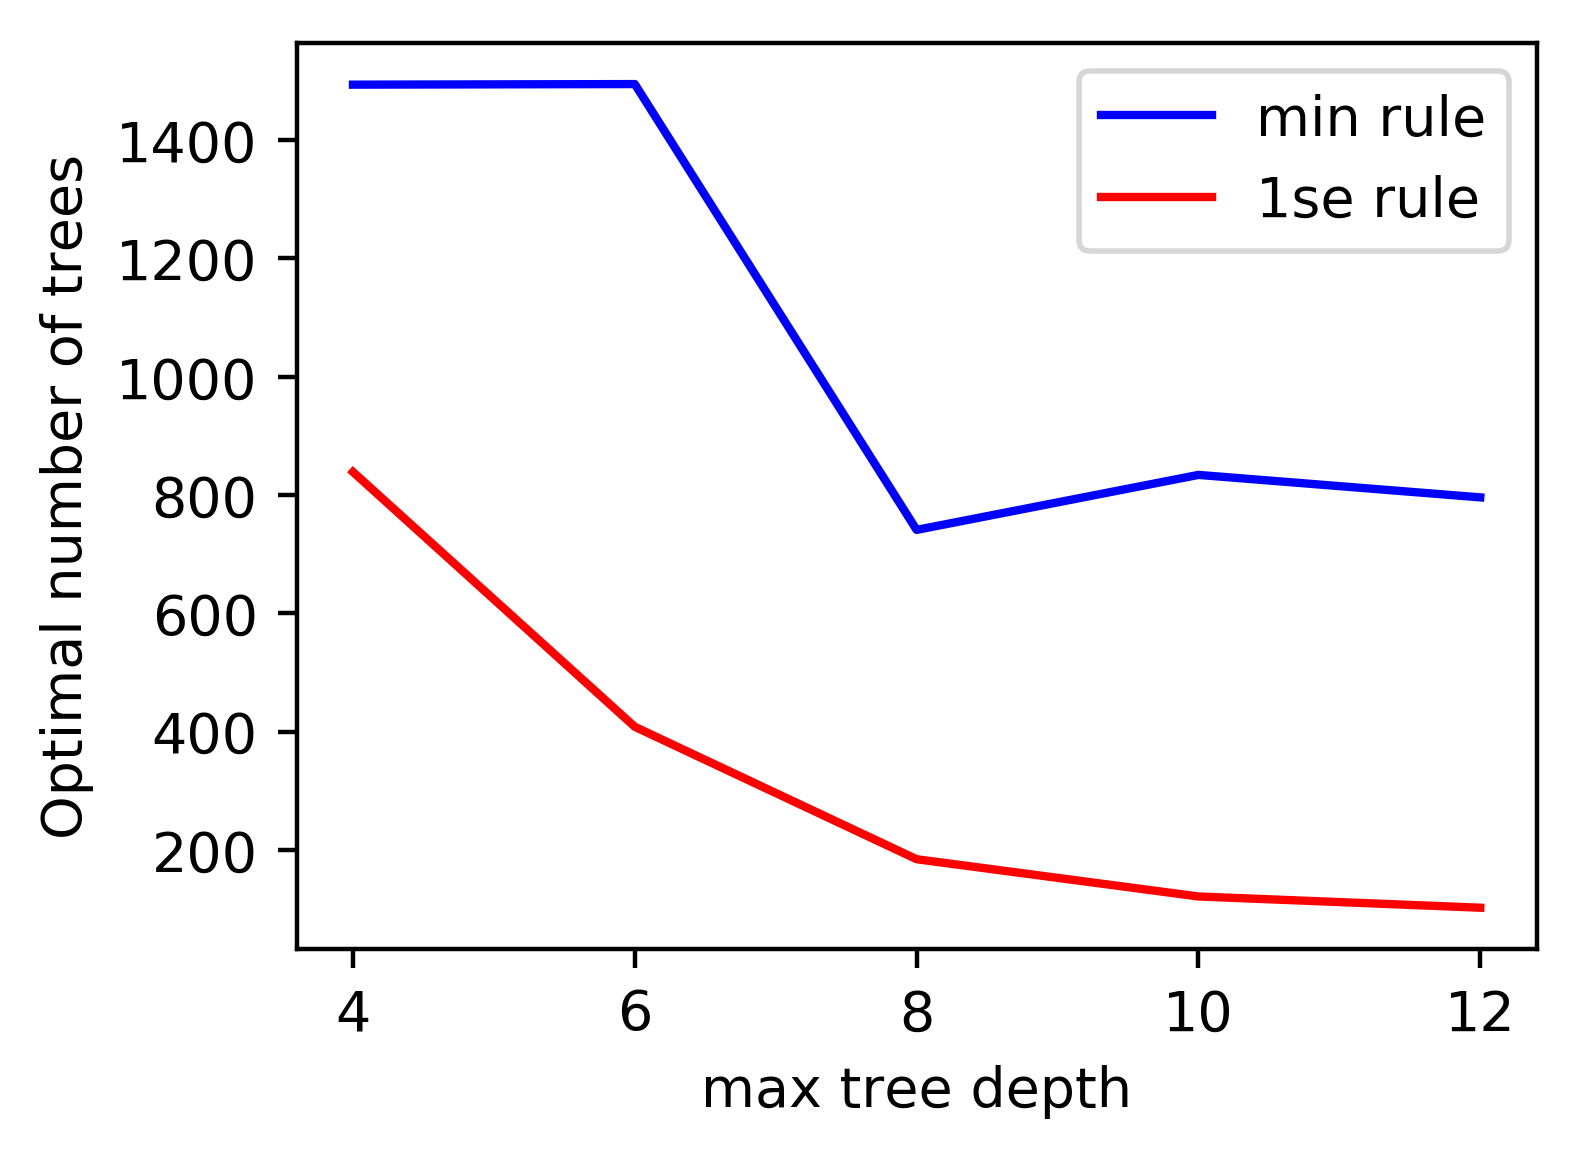

In [22]:
plt.plot(max_depth, boosting_rounds_min, label = 'min rule', color = 'b')
plt.plot(max_depth, boosting_rounds_1se, label = '1se rule', color = 'r')
plt.xlabel("max tree depth")
plt.ylabel('Optimal number of trees')
plt.legend()
plt.show()

In [18]:
# for max_depth in [4, 6, 8, 10, 12]:
#     print("The optimal number of boosting rounds for max depth = {} is {}".format(
#         max_depth, len(cv_results[str(max_depth)][0])))

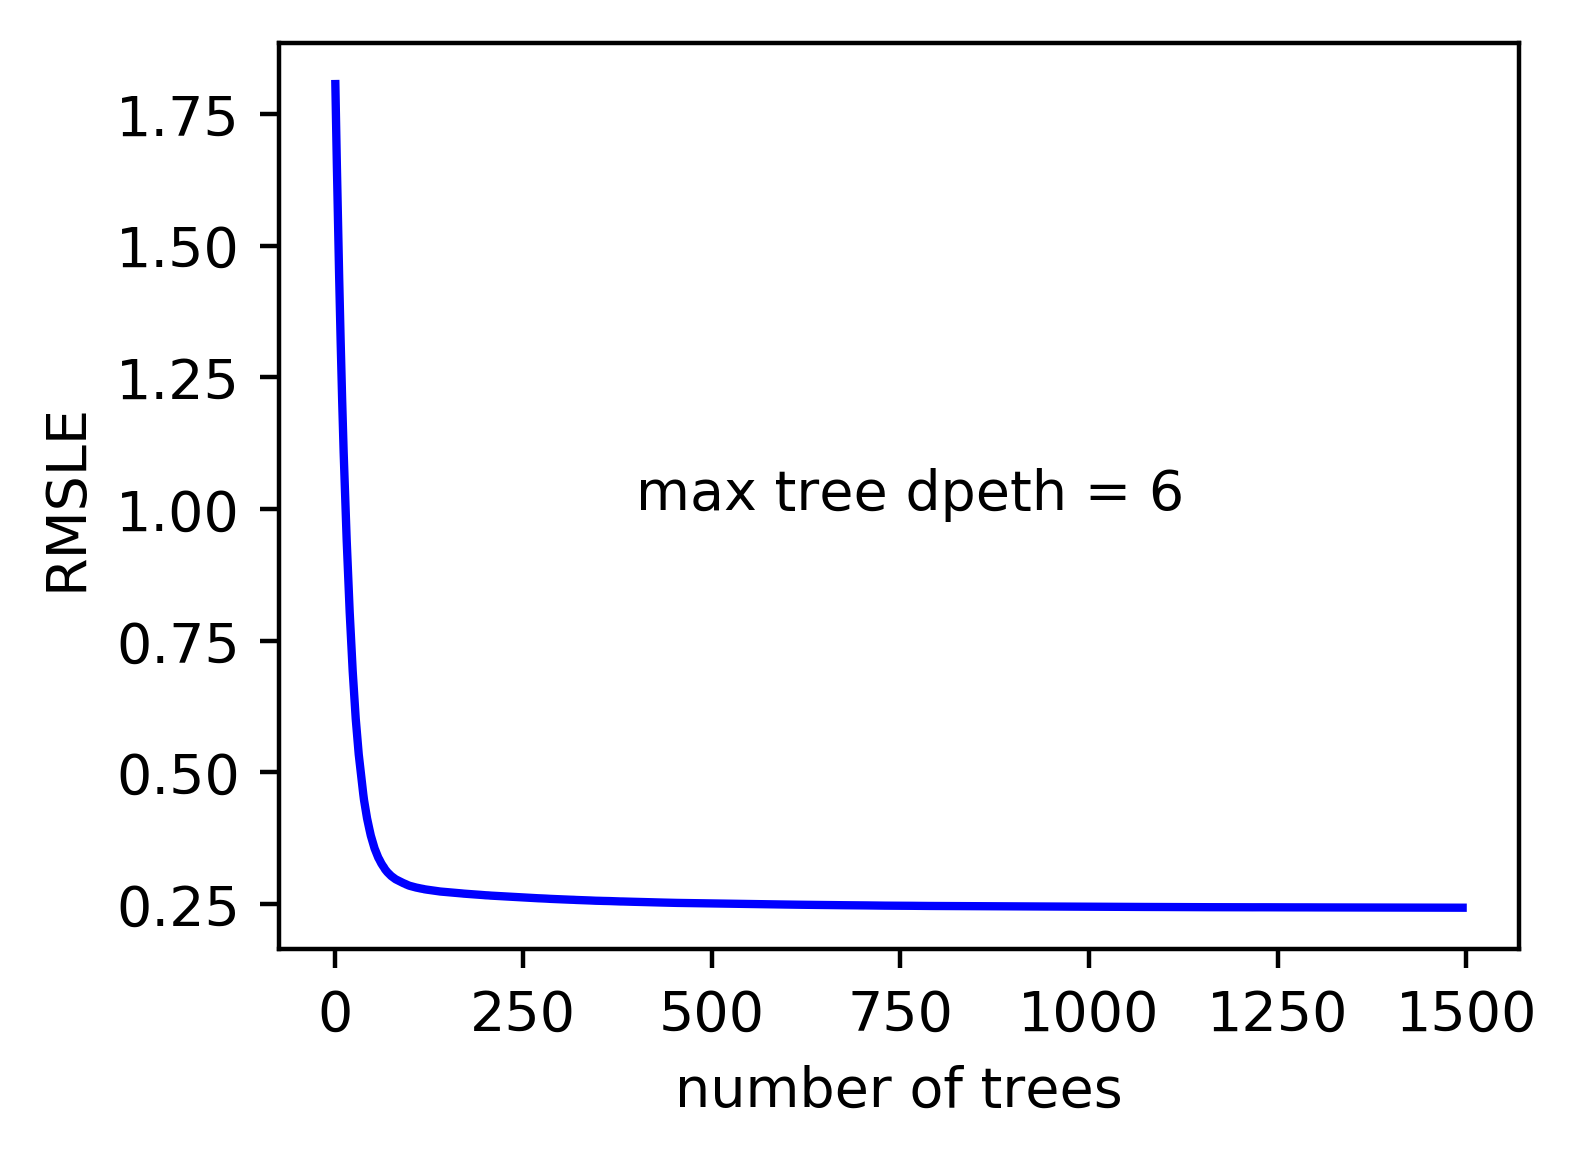

In [39]:

# plt.errorbar(x = range(1, cv_results['6'][2]+1)[::100],
#              y = cv_results['6'][0]['test-rmse-mean'][::100], 
#              yerr = cv_results['6'][0]['test-rmse-std'][::100], color = 'b', capsize = 1)



plt.plot(range(1, cv_results['6'][2]+1),
              cv_results['6'][0]['test-rmse-mean'], 
             color = 'b')

plt.xlabel("number of trees")
ax =plt.gca()
ax.text(400, 1, "max tree dpeth = 6")
plt.ylabel('RMSLE')
plt.show()

In [ ]:
cv

In [19]:
# def ceate_feature_map(features):
#     outfile = open('xgb.fmap', 'w')
#     i = 0
#     for feat in features:
#         outfile.write('{0}\t{1}\tq\n'.format(i, feat))
#         i = i + 1

#         outfile.close()

# ceate_feature_map(df_columns)
# importance = model.get_fscore(fmap='xgb.fmap')
# importance = sorted(importance.items(), key=operator.itemgetter(1))

# df = pd.DataFrame(importance, columns=['feature', 'fscore'])
# df['fscore'] = df['fscore'] / df['fscore'].sum()

# plt.figure()
# # df.plot()
# df.iloc[-50:, :].plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
# plt.title('XGBoost Feature Importance')
# plt.xlabel('relative importance')
# plt.gcf().savefig('feature_importance_xgb.png')
# plt.show()